In [ ]:
import os
import openai
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv

In [2]:
load_dotenv()  # Load environment variables from .env file

# Ensure the OPENAI_API_KEY is set
openai.api_key = os.getenv("OPENAI_API_KEY")
if openai.api_key is None:
    raise ValueError("OPENAI_API_KEY environment variable not set")

client = openai.OpenAI()

# Images and vision
How to understand or generate images. The OpenAI API offers several endpoints to process images as input or generate them as output, enabling us to build powerful multimodal applications:
- Responses API: Analyze images and use them as input and/or generate images as output
- Images API: Generate images as output, optionally using images as input

## Generate or edit images
We can generate or edit images using the Image API or the Responses API. 

The latest image generation model, **gpt-image-1**, is a natively multimodal large language model. It can understand text and images and leverage its broad world knowledge to generate images with better instruction following and contextual awareness. In constrast, there are also other specialized image generation models - DALL·E 2 and 3 - which don't have the same inherent understanding of the world as GPT Image.

**Choosing the right API**
- If we only need to generate or edit a single image from one prompt, the Image API is our best choice.
- If we want to build conversational, editable image experiences with GPT Image or display partial images during generation, go with the Responses API.

Both APIs let us customize output — adjust quality, size, format, compression, and enable transparent backgrounds.

### Generating images

#### Using Response API
The Responses API allows you to generate images as part of conversations or multi-step flows. It supports image generation as a built-in tool, and accepts image inputs and outputs within context.

Compared to the Image API, it adds:
- Multi-turn editing: Iteratively make high fidelity edits to images with prompting
- Streaming: Display partial images as the final output is being generated to improve perceived latency
- Flexible inputs: Accept image File IDs as input images, not just bytes

The image generation tool in responses only supports **gpt-image-1**.

In [ ]:
print("Processing prompt...")
response = client.responses.create(
    model="gpt-4.1-mini",
    input="Generate an image of gray tabby cat hugging an otter with an orange scarf",
    tools=[{"type": "image_generation"}],
)
print("Ok")

# Save the image to a file
image_data = [
    output.result for output in response.output if output.type == "image_generation_call"
]

if image_data:
    image_base64 = image_data[0]
    with open("arquivos/cat_and_otter.png", "wb") as f:
        f.write(base64.b64decode(image_base64))

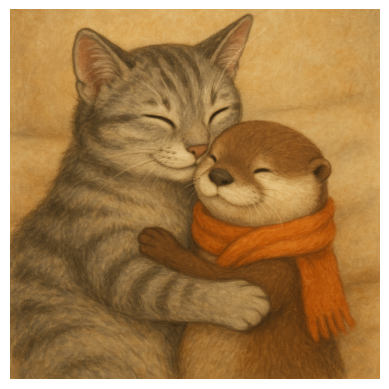

In [9]:
img = mpimg.imread(f"arquivos/cat_and_otter.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()

**Multi-turn image generation**

With the Responses API, you can build multi-turn conversations involving image generation either by providing image generation calls outputs within context (you can also just use the image ID), or by using the previous_response_id parameter. This makes it easy to iterate on images across multiple turns—refining prompts, applying new instructions, and evolving the visual output as the conversation progresses.

In [ ]:
# Follow up
print("Processing prompt...")
response_fwup = client.responses.create(
    model="gpt-4.1-mini",
    previous_response_id=response.id,
    input="Now make it look realistic",
    tools=[{"type": "image_generation"}],
)
print("Ok")

image_data_fwup = [
    output.result
    for output in response_fwup.output
    if output.type == "image_generation_call"
]

if image_data_fwup:
    image_base64 = image_data_fwup[0]
    with open("arquivos/cat_and_otter_realistic.png", "wb") as f:
        f.write(base64.b64decode(image_base64))

Processing prompt...


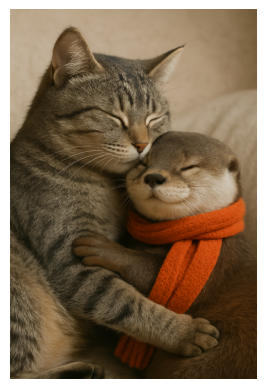

In [11]:
img = mpimg.imread(f"arquivos/cat_and_otter_realistic.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()

**Streaming**

The Responses API also supports streaming image generation. This allows us to stream partial images as they are generated, providing a more interactive experience.

We can adjust the partial_images parameter to receive 1-3 partial images.

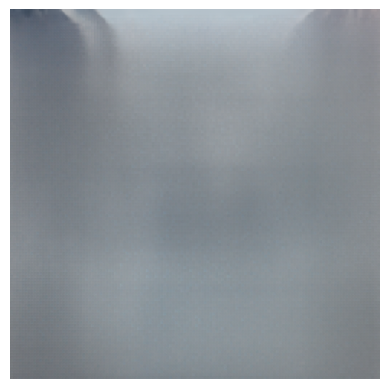

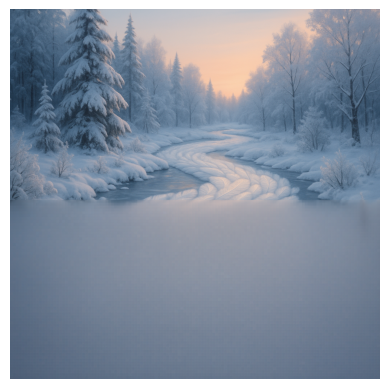

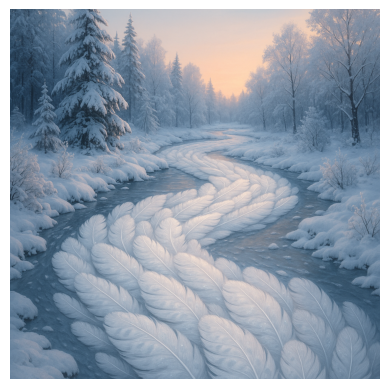

In [25]:
stream = client.responses.create(
    model="gpt-4.1-mini",
    input="Draw a gorgeous image of a river made of white owl feathers, snaking its way through a serene winter landscape",
    stream=True,
    tools=[{"type": "image_generation", "partial_images": 2}],
)

for event in stream:
    if event.type == "response.image_generation_call.partial_image":
        idx = event.partial_image_index
        image_base64 = event.partial_image_b64
        image_bytes = base64.b64decode(image_base64)
        with open(f"arquivos/river{idx}.png", "wb") as f:
            f.write(image_bytes)
        
        img = mpimg.imread(f"arquivos/river{idx}.png")
        fig, ax = plt.subplots()
        ax.set_axis_off()
        ax.imshow(img)
        plt.show()

#### Using Image API
The Image API provides three endpoints, each with distinct capabilities:

- Generations: Generate images from scratch based on a text prompt
- Edits: Modify existing images using a new prompt, either partially or entirely
- Variations: Generate variations of an existing image (available with DALL·E 2 only)

This API supports **gpt-image-1** as well as **dall-e-2** and **dall-e-3**.

In [ ]:
client2 = openai.OpenAI()

prompt = """
A children's book drawing of a veterinarian using a stethoscope to 
listen to the heartbeat of a baby otter.
"""

result = client2.images.generate(
    model="dall-e-3",
    prompt=prompt,
    size="1024x1024",
    quality="standard",
    style="natural"
)

In [17]:
result

ImagesResponse(created=1749567932, data=[Image(b64_json=None, revised_prompt="An illustration in the style of a classic children's picture book depicting a South Asian male veterinarian attentively using a stethoscope to listen to the heartbeat of a charming baby otter. The veterinarian is gentle and caring, mirroring the innocence and appeal of the baby otter. The environment should be a typical veterinary clinic, comforting and serene, imbued with a sense of care and professionalism.", url='https://oaidalleapiprodscus.blob.core.windows.net/private/org-yQPsOUbWKHGkWlYzpmtjTEeC/user-jrje4XVGmfCp10IxIKZJB96Z/img-C9cg6dXwEsnZZFpL0MGcsAVn.png?st=2025-06-10T14%3A05%3A32Z&se=2025-06-10T16%3A05%3A32Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=475fd488-6c59-44a5-9aa9-31c4db451bea&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2025-06-10T11%3A49%3A43Z&ske=2025-06-11T11%3A49%3A43Z&sks=b&skv=2024-08-04&sig=MwRzyUPH/PH9NPTSHZPG8CgjFEmf5fjOUmreSuwrhi4%3D')], usage=None)

In [20]:
result.data[0].revised_prompt

"An illustration in the style of a classic children's picture book depicting a South Asian male veterinarian attentively using a stethoscope to listen to the heartbeat of a charming baby otter. The veterinarian is gentle and caring, mirroring the innocence and appeal of the baby otter. The environment should be a typical veterinary clinic, comforting and serene, imbued with a sense of care and professionalism."

In [21]:
result.data[0].url

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-yQPsOUbWKHGkWlYzpmtjTEeC/user-jrje4XVGmfCp10IxIKZJB96Z/img-C9cg6dXwEsnZZFpL0MGcsAVn.png?st=2025-06-10T14%3A05%3A32Z&se=2025-06-10T16%3A05%3A32Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=475fd488-6c59-44a5-9aa9-31c4db451bea&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2025-06-10T11%3A49%3A43Z&ske=2025-06-11T11%3A49%3A43Z&sks=b&skv=2024-08-04&sig=MwRzyUPH/PH9NPTSHZPG8CgjFEmf5fjOUmreSuwrhi4%3D'

In [22]:
import requests

# Download the image from the URL
image_data = requests.get(result.data[0].url).content

# Save the image to a file
with open("arquivos/otter.png", "wb") as f:
    f.write(image_data)

In [ ]:
# Open image using PIL and display it - just to try it out
from PIL import Image
img = Image.open(f"arquivos/otter.png")
img.show()

### Editing images
The image edits endpoint lets us:
- Edit existing images
- Generate new images using other images as a reference
- Edit parts of an image by uploading an image and mask indicating which areas should be replaced (a process known as inpainting)

#### Generate new images using other images as a reference

##### Response API
With the Responses API, we can provide input images in 2 different ways:
- By providing an image as a Base64-encoded data URL
- By providing a file ID (created with the Files API)

In [ ]:
# Files API
def create_file(client, file_path):
  with open(file_path, "rb") as file_content:
    result = client.files.create(
        file=file_content,
        purpose="vision",
    )
    return result.id

In [ ]:
# Base64
def encode_image(file_path):
    with open(file_path, "rb") as f:
        base64_image = base64.b64encode(f.read()).decode("utf-8")
    return base64_image

In [ ]:
client = openai.OpenAI()

prompt = """Generate a photorealistic image of a gift basket on a white background 
labeled 'Relax & Unwind' with a ribbon and handwriting-like font, 
containing all the items in the reference pictures."""

base64_image1 = encode_image("body-lotion.png")
base64_image2 = encode_image("soap.png")
file_id1 = create_file(client, "body-lotion.png")
file_id2 = create_file(client, "incense-kit.png")

response = client.responses.create(
    model="gpt-4.1",
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt},
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image1}",
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image2}",
                },
                {
                    "type": "input_image",
                    "file_id": file_id1,
                },
                {
                    "type": "input_image",
                    "file_id": file_id2,
                }
            ],
        }
    ],
    tools=[{"type": "image_generation"}],
)

image_generation_calls = [
    output
    for output in response.output
    if output.type == "image_generation_call"
]

image_data = [output.result for output in image_generation_calls]

if image_data:
    image_base64 = image_data[0]
    with open("arquivos/gift-basket.png", "wb") as f:
        f.write(base64.b64decode(image_base64))
else:
    print(response.output.content)

In [ ]:
img = mpimg.imread(f"arquivos/gift-basket.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()

##### Image API

In [ ]:
client2 = openai.OpenAI()

prompt = """
Generate a photorealistic image of a gift basket on a white background 
labeled 'Relax & Unwind' with a ribbon and handwriting-like font, 
containing all the items in the reference pictures.
"""

result = client2.images.edit(
    model="gpt-image-1",
    image=[
        open("body-lotion.png", "rb"),
        open("bath-bomb.png", "rb"),
        open("incense-kit.png", "rb"),
        open("soap.png", "rb"),
    ],
    prompt=prompt
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

# Save the image to a file
with open("arquivos/gift-basket2.png", "wb") as f:
    f.write(image_bytes)

In [ ]:
img = mpimg.imread(f"arquivos/gift-basket2.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()

#### Edit an image using a mask (inpainting)

##### Response API

In [ ]:
client = openai.OpenAI()

fileId = create_file(client, "sunlit_lounge.png")
maskId = create_file(client, "mask.png")

response = client.responses.create(
    model="gpt-4o",
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": "generate an image of the same sunlit indoor lounge area with a pool but the pool should contain a flamingo",
                },
                {
                    "type": "input_image",
                    "file_id": fileId,
                }
            ],
        },
    ],
    tools=[
        {
            "type": "image_generation",
            "quality": "high",
            "input_image_mask": {
                "file_id": maskId,
            },
        },
    ],
)

image_data = [
    output.result
    for output in response.output
    if output.type == "image_generation_call"
]

if image_data:
    image_base64 = image_data[0]
    with open("lounge.png", "wb") as f:
        f.write(base64.b64decode(image_base64))

In [ ]:
img = mpimg.imread(f"arquivos/lounge.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()

##### Image API

In [ ]:
client2 = openai.OpenAI()

result = client2.images.edit(
    model="dall-e-2",
    image=open("sunlit_lounge.png", "rb"),
    mask=open("mask.png", "rb"),
    prompt="A sunlit indoor lounge area with a pool containing a flamingo"
)

In [ ]:
# Download the image from the URL
image_data = requests.get(result.data[0].url).content

# Save the image to a file
with open("arquivos/composition.png", "wb") as f:
    f.write(image_data)

#### Creating Variations

##### Image API

In [ ]:
result = client2.images.create_variation(
    image=open("arquivos/composition.png", "rb")
)

# Download the image from the URL
image_data = requests.get(result.data[0].url).content

# Save the image to a file
with open("arquivos/composition_variation.png", "wb") as f:
    f.write(image_data)

img = mpimg.imread(f"arquivos/composition_variation.png")
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(img)
plt.show()